<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session5/Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code2**
**Target**
1.  Added 1 more convolution layer and Gap Layer
2. Changed the number of kernels in some conv layers
3. Increased the capacity

**Results**
1.  Parameters - 9634
2.  Best training accuracy- 98.67
3.  Best test accuracy - 99.4


**Analysis**
1. Target is reached, but only once.
2. Model is still under-fitting












# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


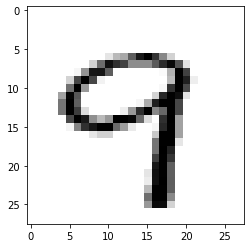

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

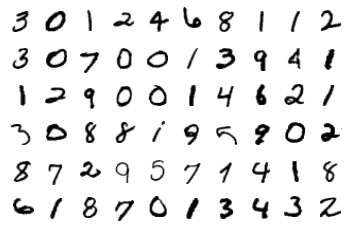

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(                      
            
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 26, RF = 3
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 24, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.1),

        nn.MaxPool2d(kernel_size=(2,2)), #Op_size = 12, RF = 6

        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 10, RF = 10   
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 8, RF = 14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),#Op_size = 6, RF = 18 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 6, RF = 22 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1),

        nn.AvgPool2d(kernel_size=6),

        # nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False ), #Op_size = 4, RF = 22
        # nn.ReLU(),
        # nn.BatchNorm2d(16),
        # nn.Dropout2d(0.15),

        # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 2, RF = 26
        # nn.ReLU(),
        # nn.BatchNorm2d(16),
        # nn.Dropout2d(0.15),

        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, RF = 28
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1106228232383728 Batch_id=468 Accuracy=84.09: 100%|██████████| 469/469 [00:10<00:00, 46.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.14310185611248016 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:10<00:00, 46.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.058640848845243454 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:10<00:00, 45.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.193791925907135 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:09<00:00, 47.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.0942261591553688 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:09<00:00, 47.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.046862516552209854 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.025302784517407417 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:09<00:00, 46.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.044046808034181595 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:10<00:00, 44.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.1625034064054489 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.06281500309705734 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 45.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.04103945568203926 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:10<00:00, 46.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.02860628254711628 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 46.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.06542704999446869 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:09<00:00, 46.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.014062531292438507 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 46.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.01709422655403614 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 46.06it/s]



Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

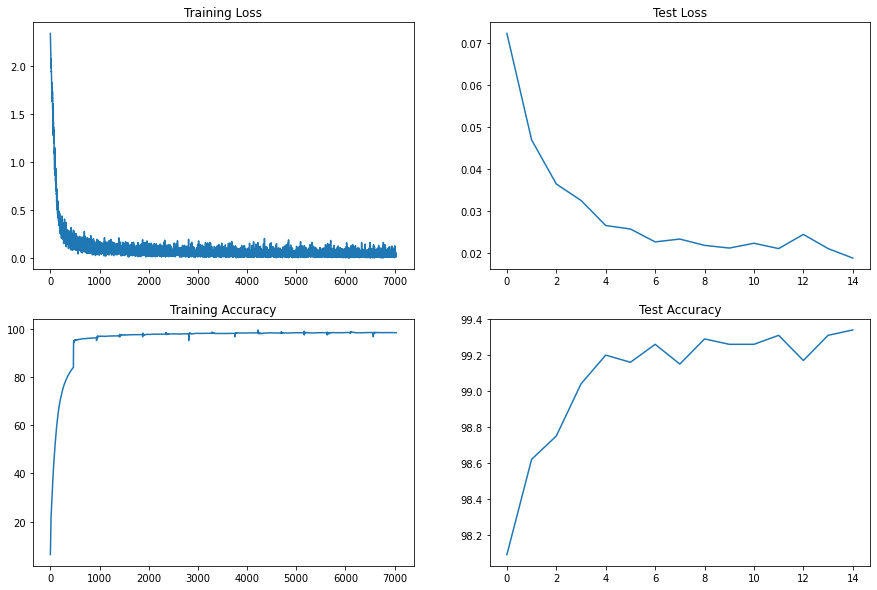

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")